# Testing of KMeansOptimN
In this notebook we will test the KMeansOptimN estimator.

In [1]:
from Kmeans_optimal_n import KMeansOptimN
import seaborn as sns
import matplotlib.pyplot as plt

First we must create a dataset where we know the ground truth to test the etimators ability to find the optimal number of clusters

In [2]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=10000, n_features=10, centers=12)

The time this algorithm takes relies specifically on the range of topics to search over. this relationship is linear meaning for every number in the cluster search range the base KMeasn algorithm is fit once. so if we are searching over a range of 50 than there will be 50 calls to KMeans.fit().

In [3]:
%%timeit -r 10 -n 5
kmm = KMeansOptimN()
kmm.fit(X)

348 ms ± 43.7 ms per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [4]:
kmm = KMeansOptimN()
clust, chs, dbs = kmm.get_optimal_clusters(X, cluster_range=(2, 21, 1))

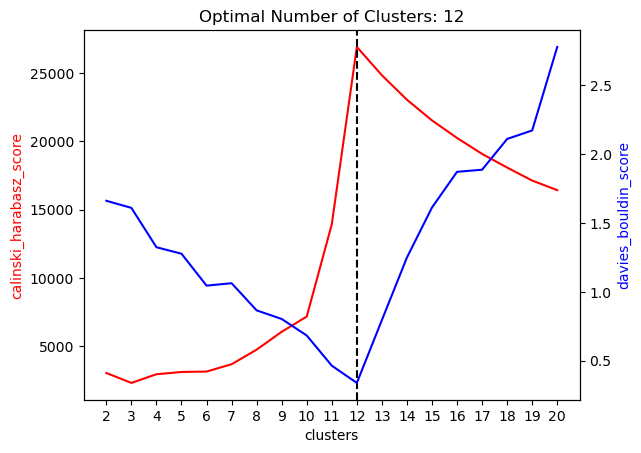

In [5]:
fix, ax = plt.subplots()
ax1 = ax.twinx()
x_tics = [cl[0] for cl in chs]

sns.lineplot(x=x_tics, y=[score[1] for score in chs], ax=ax, color='r')
sns.lineplot(x=x_tics, y=[score[1] for score in dbs], ax=ax1, color='b')

ax.axvline(clust, color='k', ls='--')

ax.set_xlabel('clusters')
ax.set_ylabel('calinski_harabasz_score', color='r')
ax1.set_ylabel('davies_bouldin_score', color='b')
ax.set_title(f'Optimal Number of Clusters: {clust}')

ax.set_xticks(x_tics)

plt.show()

In [6]:
# test in pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


pipe = make_pipeline(StandardScaler(), KMeansOptimN(), verbose=True)
pipe.fit(X)
preds = pipe.predict(X)
print(preds.shape)
preds

[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.0s
[Pipeline] ...... (step 2 of 2) Processing kmeansoptimn, total=   0.5s
(10000,)


array([7, 1, 6, ..., 0, 7, 6], dtype=int32)

In [7]:
from sklearn.metrics import adjusted_mutual_info_score
adjusted_mutual_info_score(y, preds)

0.9146316841461097

For the final test we will create 1000 datasets with a random number of clusters in the range 2, 50. For each dataset we will fit_predict the KMeansOptimN estimator and calcuate the adjusted_mutual_info_score.

In [8]:
from random import randint
from tqdm.notebook import tqdm

def create_dataset(centers:int):
    X, y = make_blobs(n_samples=10000, n_features=10, centers=centers)
    return X, y

def score_model(X, y):
    kmm = KMeansOptimN()
    preds = kmm.fit_predict(X, cluster_range=(2, 51, 1))
    return kmm.n_clusters, adjusted_mutual_info_score(y, preds)

def test_results(test_range:int=1000):
    results = []
    for test in tqdm(range(test_range)):
        centers = randint(2, 50)
        X, y = create_dataset(centers)
        clusters, score = score_model(X, y)
        results.append((centers, clusters, score))
    
    return results

In [9]:
results = test_results()
results[:5]

  0%|          | 0/1000 [00:00<?, ?it/s]

[(4, 4, 1.0), (24, 24, 1.0), (23, 23, 1.0), (17, 17, 1.0), (39, 39, 1.0)]

In [12]:
actual, predicted, score = zip(*results)
count = 0
for item in results:
    if item[0] == item[1]:
        count += 1
print(f'percent correct: {(count / len(results))*100:.2f}%, average score: {sum(score) / len(score)}')

percent correct: 86.90%, average score: 0.9956011907889413


Looking at the results the model correctly found the exact number of clusters 86% of the time! Now lets look at the times it was not correct and see how off they were.

In [27]:
diff = [0]*len(actual)
for i in range(len(actual)):
    diff[i] = abs(actual[i] - predicted[i])
diff[:20]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0]

In [28]:
max(diff)

2

The maximum number of the model was off by was two! meaning that out of 1000 fits the model was not off of the correct number of clusters by more than two.